# **Image Classification with Convolutional Neural Networks (CNNs)**





# **Building a Convolutional Neural Network with Keras**

**Import Libraries**

In [8]:
import numpy as np
import tensorflow as tf
tf.__version__

import psutil
import GPUtil

import os,sys,humanize,psutil,GPUtil

import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import imageio
import tensorflow.keras as keras

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

**Memory Utilization Checkup (Before/After Model Execution)**

In [9]:
#CPU AND GPU LIBRARIES INSTALLATION (if you find error on import of psutil and GPUtil, please refer below)
!pip install psutil
!pip install GPUtil

In [10]:
# CHECKING THE CPU AND GPU MEMORY

# Testing the psutil library for both CPU and RAM performance details
print(psutil.cpu_percent())
print(psutil.sys.ram)
print(psutil.virtual_memory().percent)
# Testing the GPUtil library for both GPU performance details
GPUtil.showUtilization()

5.0


AttributeError: module 'sys' has no attribute 'ram'

In [ ]:
#CPU MEMORY UTILIZATION

!cat /proc/meminfo

In [ ]:
!grep MemTotal /proc/meminfo

In [ ]:
#GPU MEMORY UTILIZATION 
!nvidia-smi --query-gpu=memory.total --format=csv

In [ ]:
# Function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

## **Let's Start with Model Implementation**

**Data Acquisition and ImageDataGenerator**


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255) #Normalize the pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_dir = os.path.join('/home/ines/code/ptb-xl/X_train/')
validation_dir = os.path.join('/home/ines/code/ptb-xl/X_test/')

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

Found 23847 images belonging to 2 classes.
Found 2198 images belonging to 2 classes.


**Building the Model**

In [14]:
model = tf.keras.models.Sequential([
                                    
    # First convolution layer 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3),use_bias=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Second convolution layer 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    

    # Third convolution layer 
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Fourth convolution layer  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(8, activation='relu',use_bias=True),

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid',activity_regularizer=regularizers.L1(0.001))   

])


**Printing Model Summary**

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0

**Optimizer Implementation and model training/validation**

In [15]:
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5)])  

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99): 
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ECG_Spectrogram_Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=500,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=5, 
      callbacks = [callbacks,checkpoint]
) 

2024-04-08 16:37:16.406861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-08 16:37:16.428569: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3499910000 Hz


Epoch 1/500
10/10 [==============================] - 15s 1s/step - loss: 0.6633 - accuracy: 0.6926 - sensitivity_at_specificity_1: 0.4602 - specificity_at_sensitivity_1: 0.4626 - recall_1: 0.9183 - precision_1: 0.7318 - val_loss: 0.4720 - val_accuracy: 0.8914 - val_sensitivity_at_specificity_1: 0.2971 - val_specificity_at_sensitivity_1: 0.2590 - val_recall_1: 1.0000 - val_precision_1: 0.8914

Epoch 00001: val_accuracy improved from -inf to 0.89141, saving model to ECG_Spectrogram_Model.h5
Epoch 2/500
10/10 [==============================] - 12s 1s/step - loss: 0.5805 - accuracy: 0.7389 - sensitivity_at_specificity_1: 0.5190 - specificity_at_sensitivity_1: 0.5188 - recall_1: 1.0000 - precision_1: 0.7389 - val_loss: 0.5288 - val_accuracy: 0.9039 - val_sensitivity_at_specificity_1: 0.3984 - val_specificity_at_sensitivity_1: 0.1220 - val_recall_1: 1.0000 - val_precision_1: 0.9039

Epoch 00002: val_accuracy improved from 0.89141 to 0.90391, saving model to ECG_Spectrogram_Model.h5
Epoch 3/5

**Performance Metrics**

In [7]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity']
Validation_Recall=history.history['val_recall']
Validation_Precision=history.history['val_precision']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",max(Training_Accuracy))
print("Validation Accuracy: ",max(Validation_Accuracy))
print("Validation Specificity: ",max(Validation_Specificity))
print("Validation Sensitivity: ",max(Validation_Sensitivity))
print("Validation Recall: ",max(Validation_Recall))
print("Validation Precision: ",max(Validation_Precision))
print("Validation Loss: ",min(Validation_Loss))

NameError: name 'history' is not defined

**Accuracy Graph**

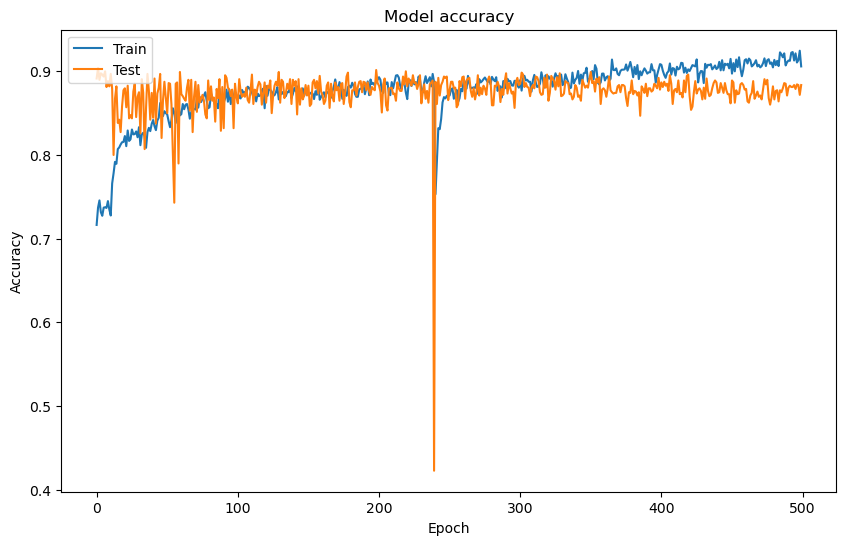

In [21]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Loss Graph**

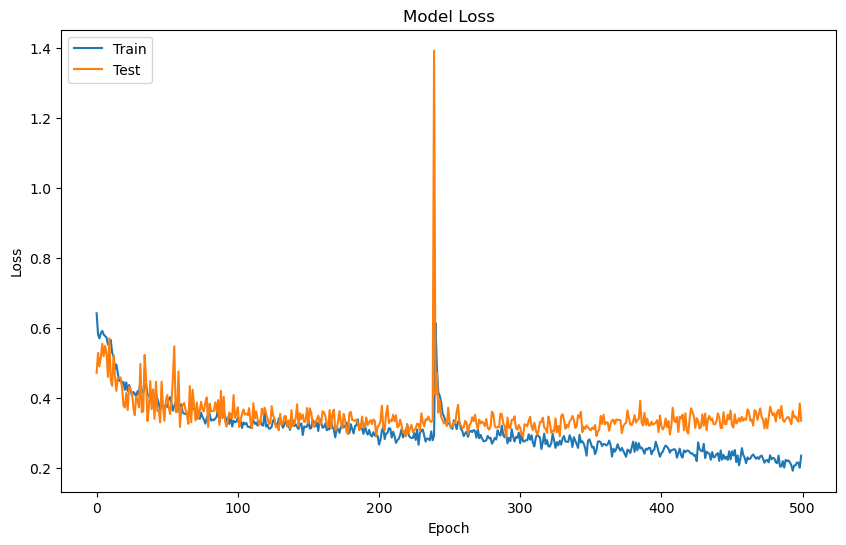

In [22]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()